In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from anm.gaze_dataloader.dataset import _create_senteces_from_data
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
sns.set_style('darkgrid')

In [2]:
positive_corr = True
eye_tracking_feature = 'dur'

In [3]:
out_dir = '/home/luca/Workspace/augmenting_nlms_meco/output/plots/attn_corr'

In [4]:
def get_src_paths(language, method, language_mode, finetuning_mode=None):
    meco_data_dir = '../augmenting_nlms_meco_data/'
    eye_tracking_dir = os.path.join(meco_data_dir, language)
    attention_extraction_output_dir = f'../output/attn_data/{task}'
    attention_dir = os.path.join(attention_extraction_output_dir, method, language, language_mode)
    return eye_tracking_dir, attention_dir

In [5]:
def load_eye_tracking_data(src_path, col):
    data = pd.read_csv(src_path, index_col=0)
    gaze_dataset = _create_senteces_from_data(data, [col], keep_id=True)
    return gaze_dataset

In [6]:
def load_model_attention(src_path):
    with open(src_path, 'r') as src_file:
        model_attention = json.load(src_file)
    return model_attention

In [7]:
def normalize_list(l):
    return ((l-np.min(l))/(np.max(l)-np.min(l))).tolist()

In [8]:
def compute_correlation(eye_tracking_dataset, model_attention_dict):
    all_human_attentions = []
    all_model_attentions = []
    feature_name = [col_name for col_name in eye_tracking_dataset.column_names if col_name not in ['id', 'text']][0]
    
    for sent_id, human_attention in zip(eye_tracking_dataset['id'], eye_tracking_dataset[feature_name]):
        model_attention = model_attention_dict[sent_id]
        all_human_attentions += human_attention #normalize_list(human_attention)
        all_model_attentions += model_attention #normalize_list(model_attention)

    s = spearmanr(all_model_attentions, all_human_attentions)
    if s.pvalue < 0.05:
        if positive_corr:
            return max(s.statistic, -s.statistic)
        else:
            return s.statistic
    else:
        return None #0.0

In [9]:
def compute_correlations_df(language, attention_dir, eye_tracking_dir):        
    training_configs = os.listdir(attention_dir)

    correlations_dict = {'training_config':[], 'layer':[], 'correlation':[], 'user':[]}
    for training_config in training_configs:
        config_attention_dir = os.path.join(attention_dir, training_config)
        for user_id in os.listdir(config_attention_dir):
            eye_tracking_path = os.path.join(eye_tracking_dir, f'{language}_{user_id}_dataset.csv')
            eye_tracking_data = load_eye_tracking_data(eye_tracking_path, eye_tracking_feature)
            
            user_attention_dir = os.path.join(config_attention_dir, user_id)
            for layer in range(12):
                layer_attention_path = os.path.join(user_attention_dir, f'{layer}.json')
                layer_attention = load_model_attention(layer_attention_path)
                corr = compute_correlation(eye_tracking_data, layer_attention)
                correlations_dict['training_config'].append(training_config)
                correlations_dict['layer'].append(layer)
                correlations_dict['correlation'].append(corr)
                correlations_dict['user'].append(user_id)
    return pd.DataFrame.from_dict(correlations_dict)

In [10]:
def plot_all_correlations(task, method, out_path, languages=['en', 'it']):
    fig, axes = plt.subplots(len(languages), 2, figsize=(15, 5*len(languages)));
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.1])
    axes = axes.flatten();
    ax_idx = 0
    for language in languages:
        for language_mode in ['mono_lingual', 'cross_lingual']:
            eye_tracking_dir, attention_dir = get_src_paths(language, method, language_mode)
            correlations_df = compute_correlations_df(language, attention_dir, eye_tracking_dir)
            language_mode_str = language_mode if language_mode == 'mono_lingual' else 'multi_lingual'
            sns.lineplot(ax=axes[ax_idx], data=correlations_df, x='layer', y='correlation', hue='training_config').set_title(f'{language}, {language_mode_str}')
            axes[ax_idx].set_ylim(-0.05, 0.88)
            axes[ax_idx].get_legend().remove()
            ax_idx += 1
    plt.tight_layout()
    legend_ax = fig.add_subplot(gs[2, :])
    legend_ax.axis('off')  # Hide the axes for the legend subplot
    bb_y = -1.5 if len(languages) == 2 else -3
    legend_ax.legend(*axes[0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, bb_y), ncol=len(correlations_df['training_config'].unique()))
    fig.savefig(out_path)

# Base

In [11]:
task = 'base'

## Attention

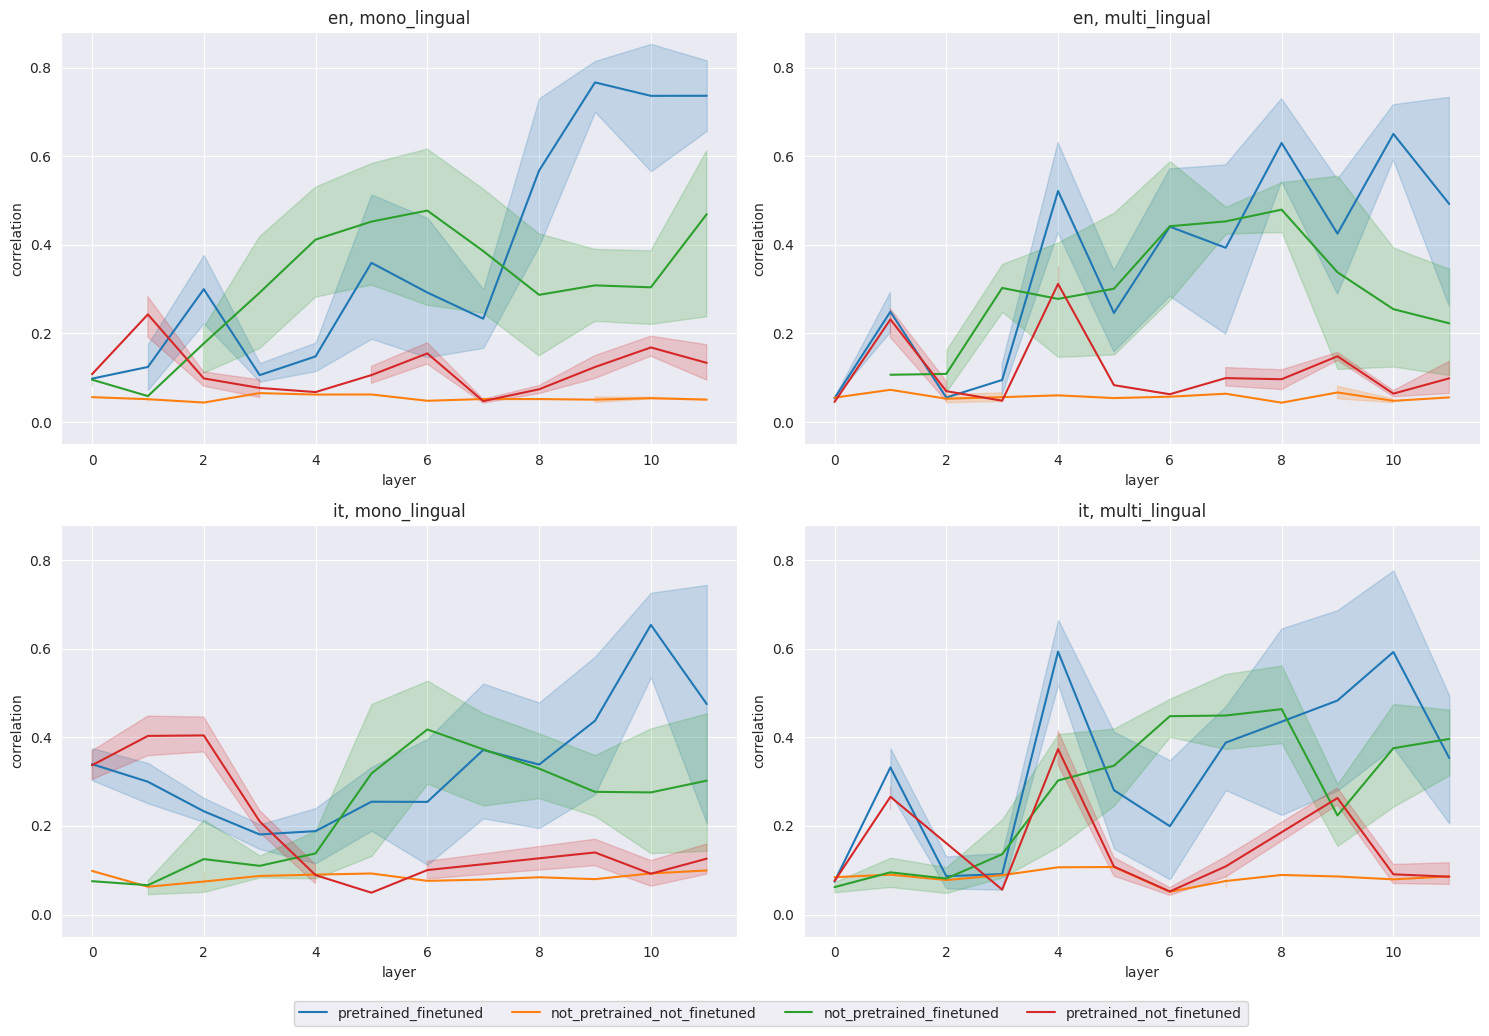

In [12]:
method = 'attention'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path)

## Alti

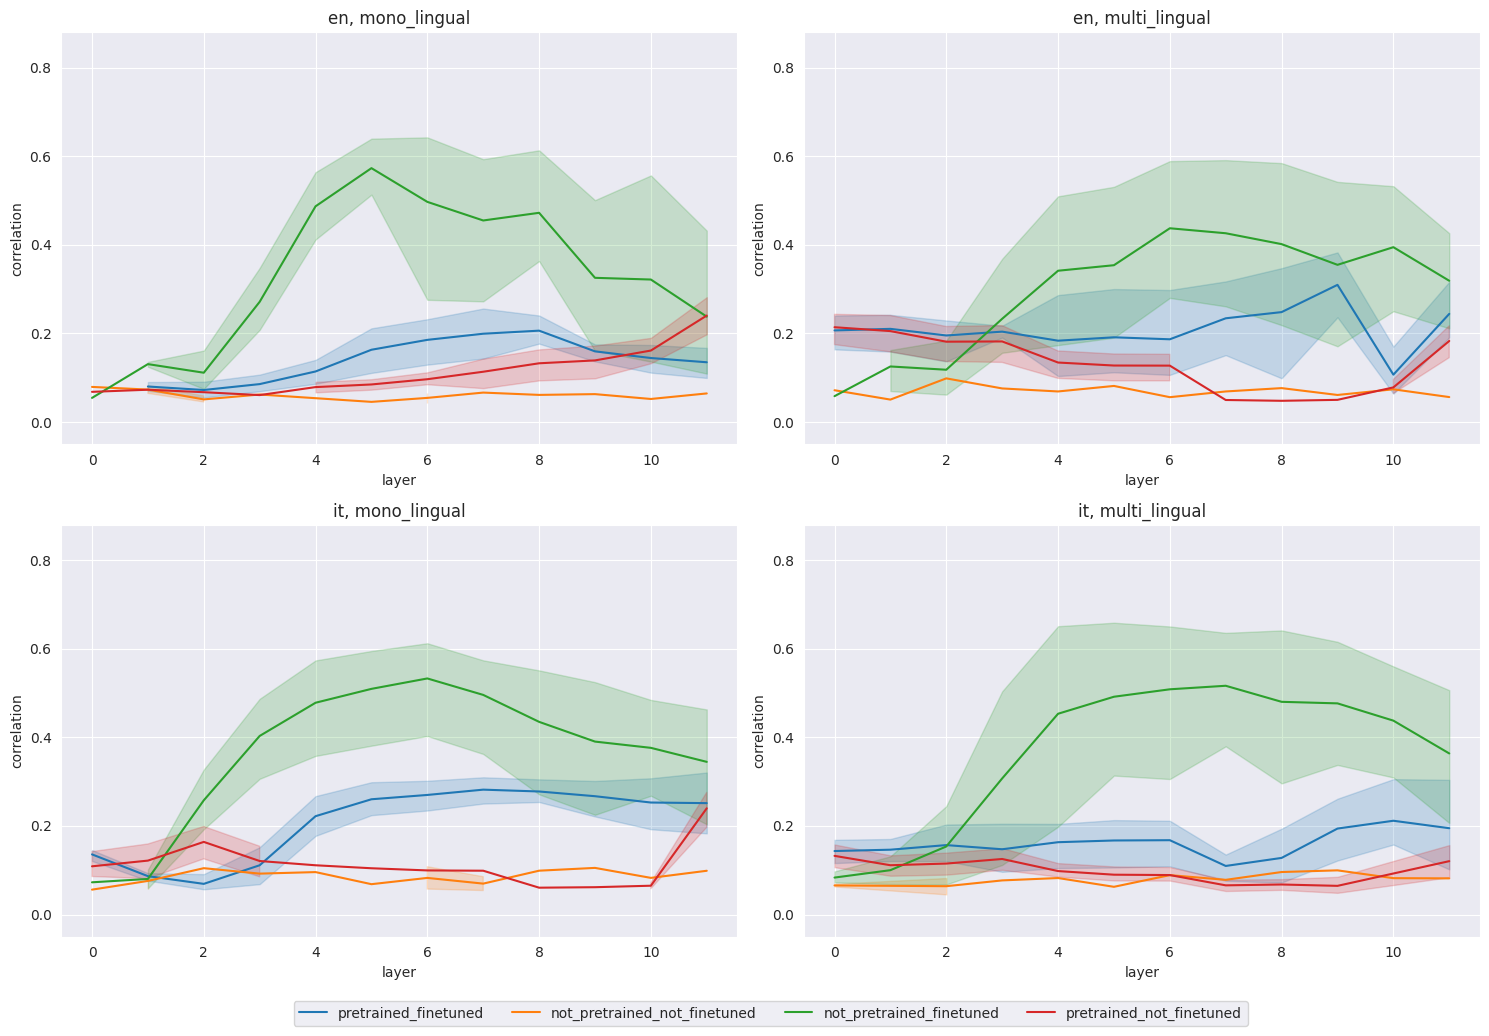

In [13]:
method = 'alti'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path)

## Valuezeroing

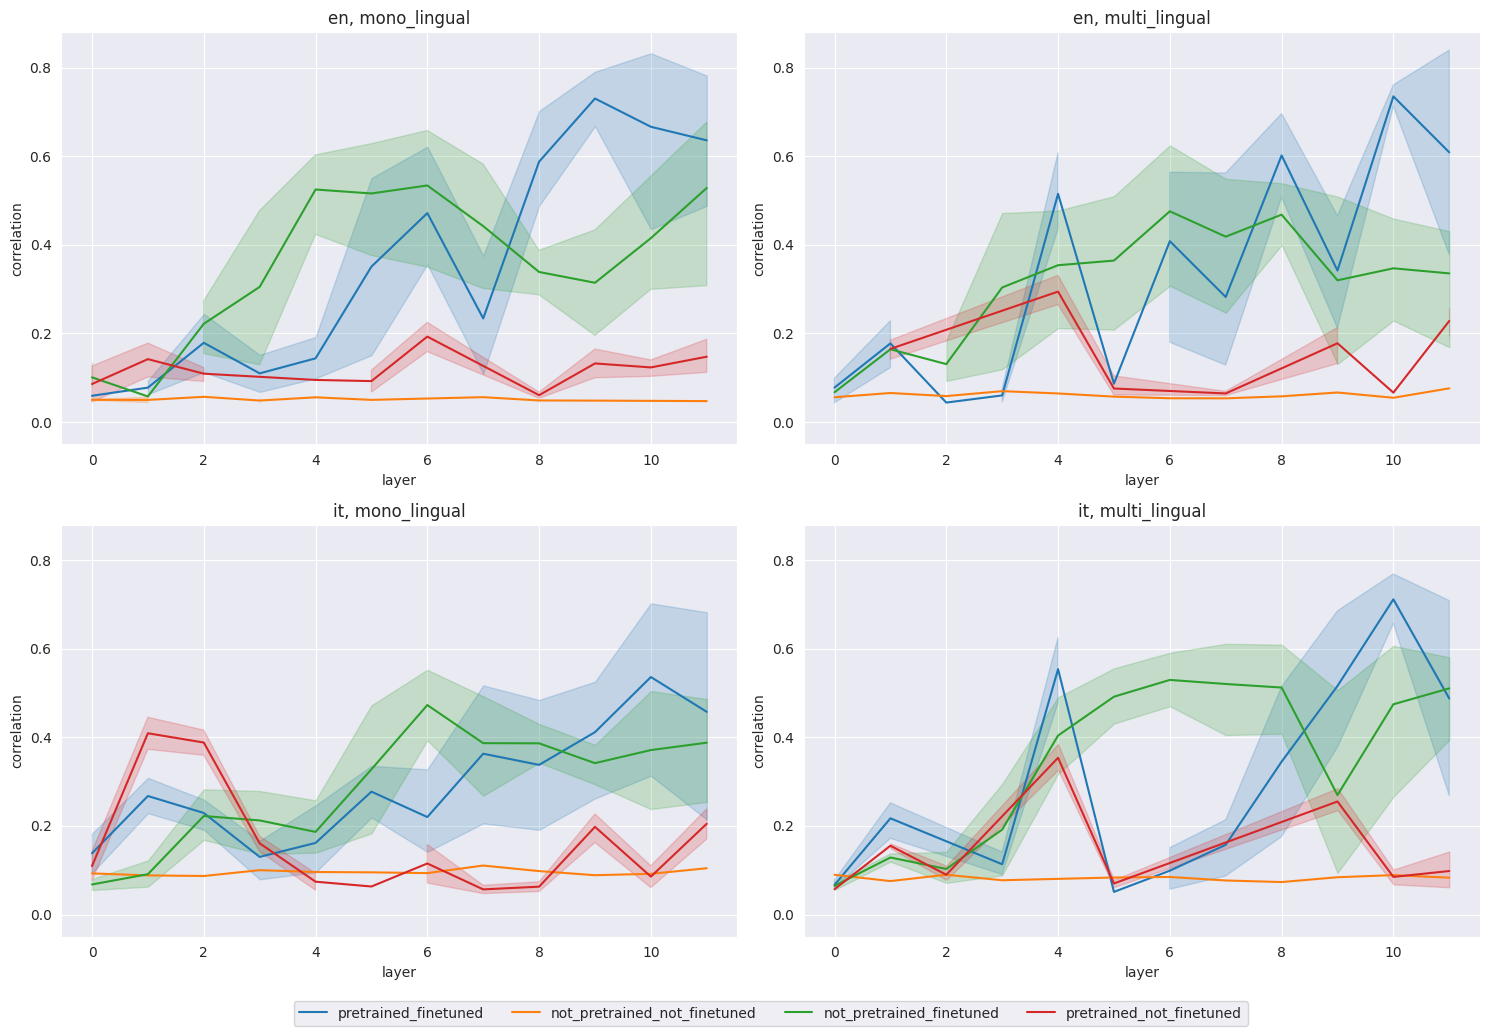

In [14]:
method = 'valuezeroing'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path)

# Complexity

In [15]:
task = 'base'

## Attention

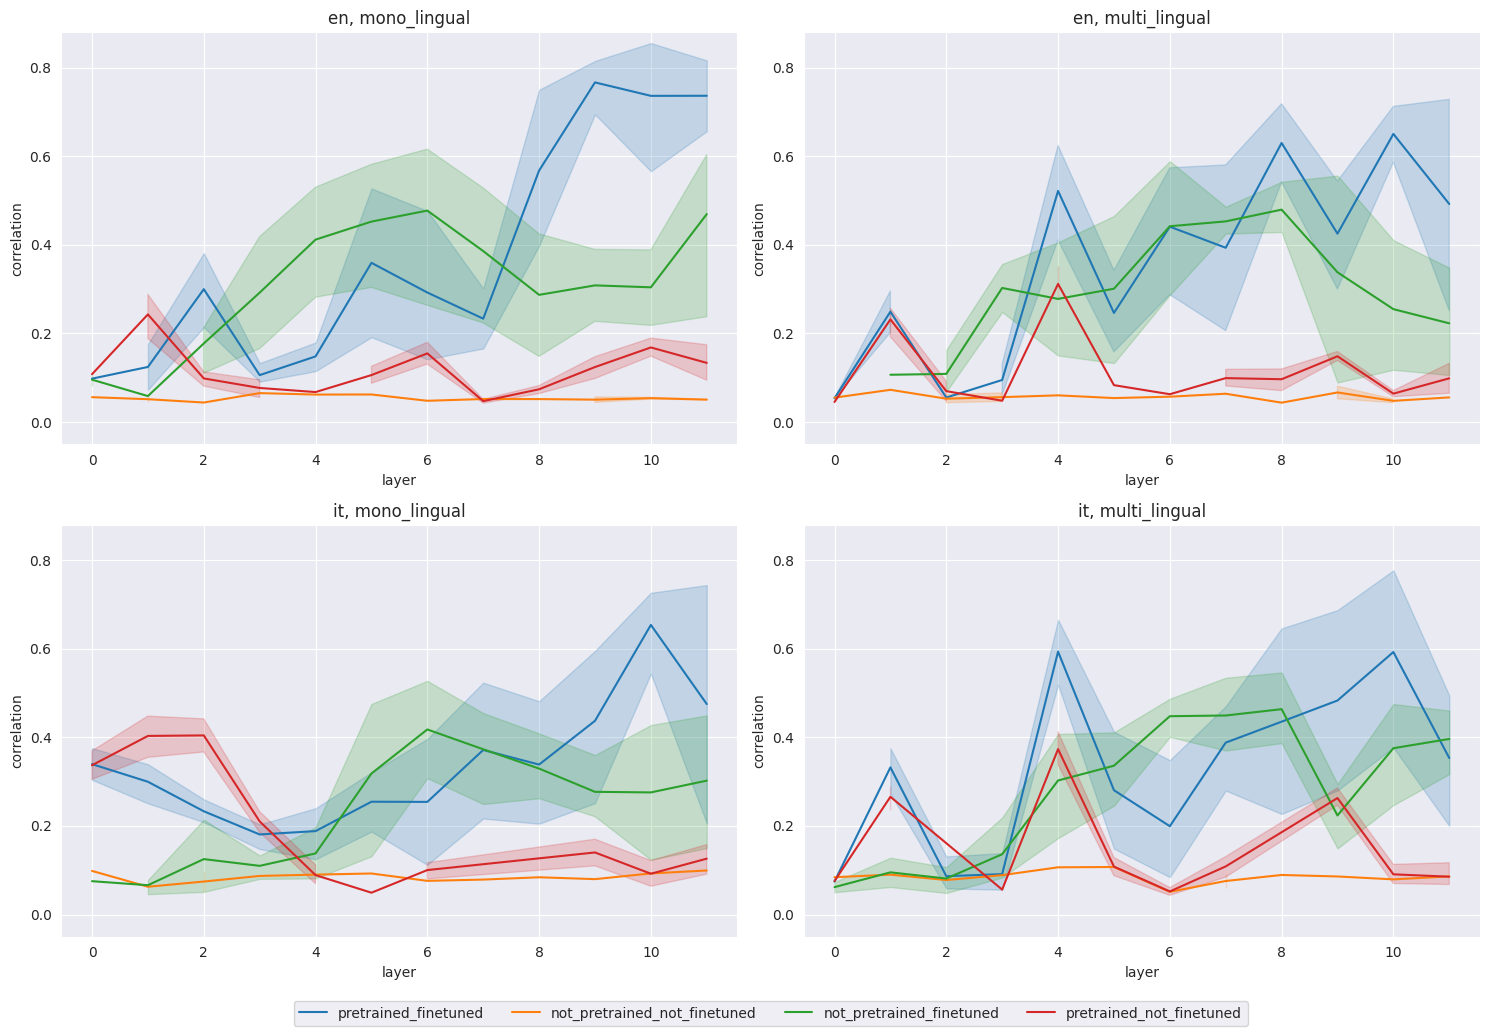

In [16]:
method = 'attention'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path)

## Alti

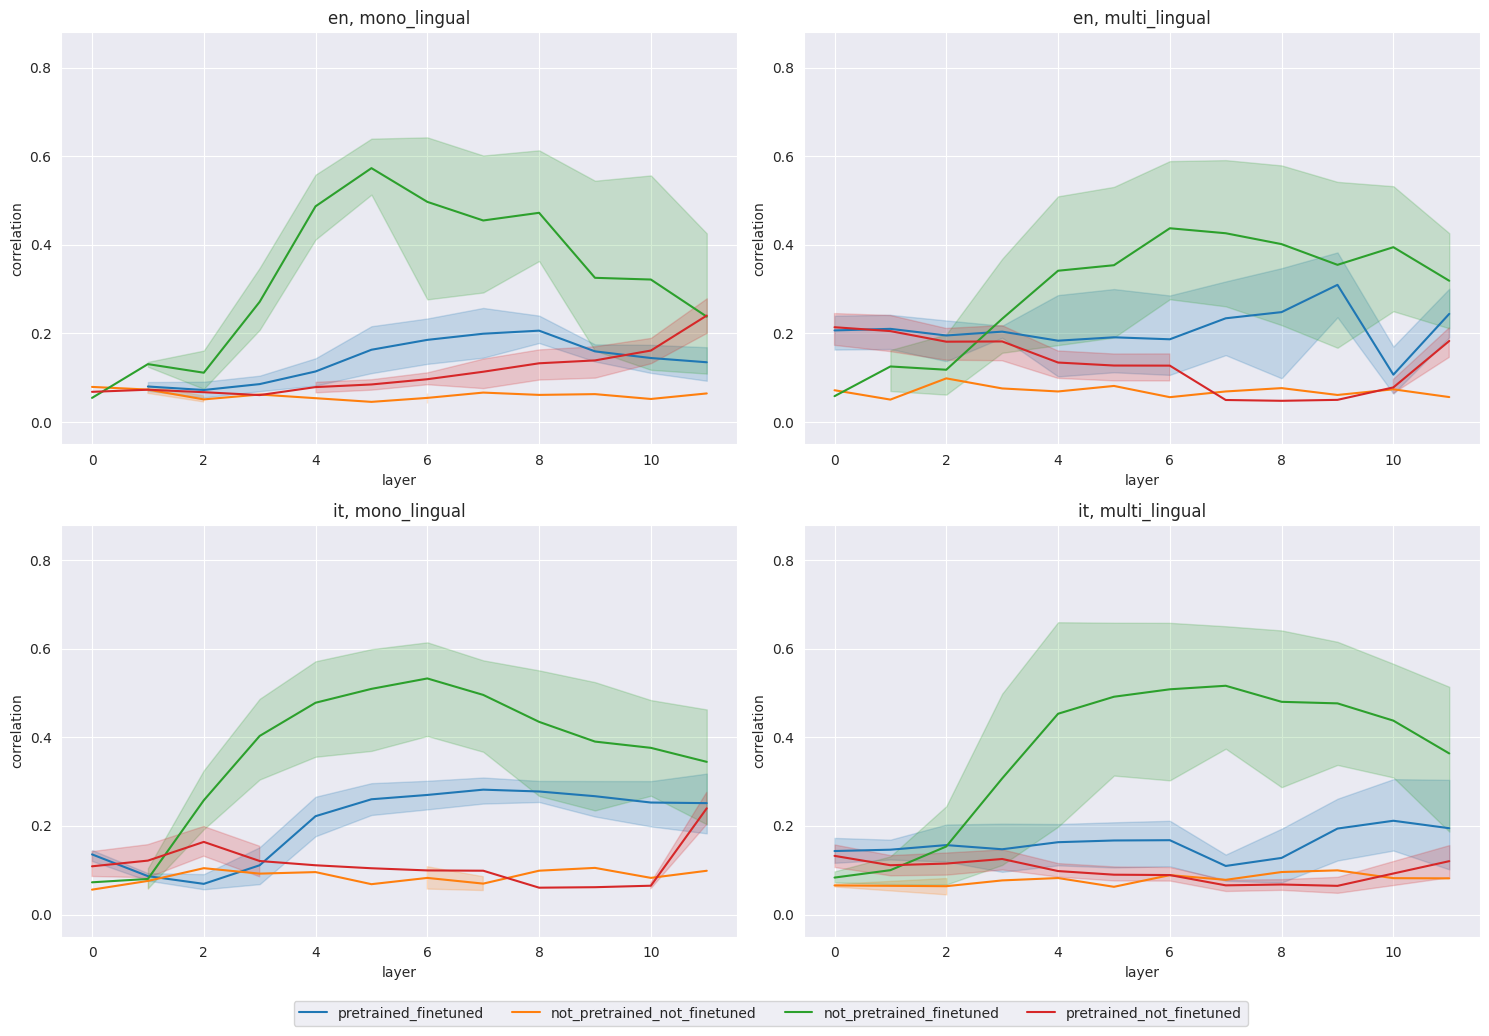

In [17]:
method = 'alti'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path)

## Valuezeroing

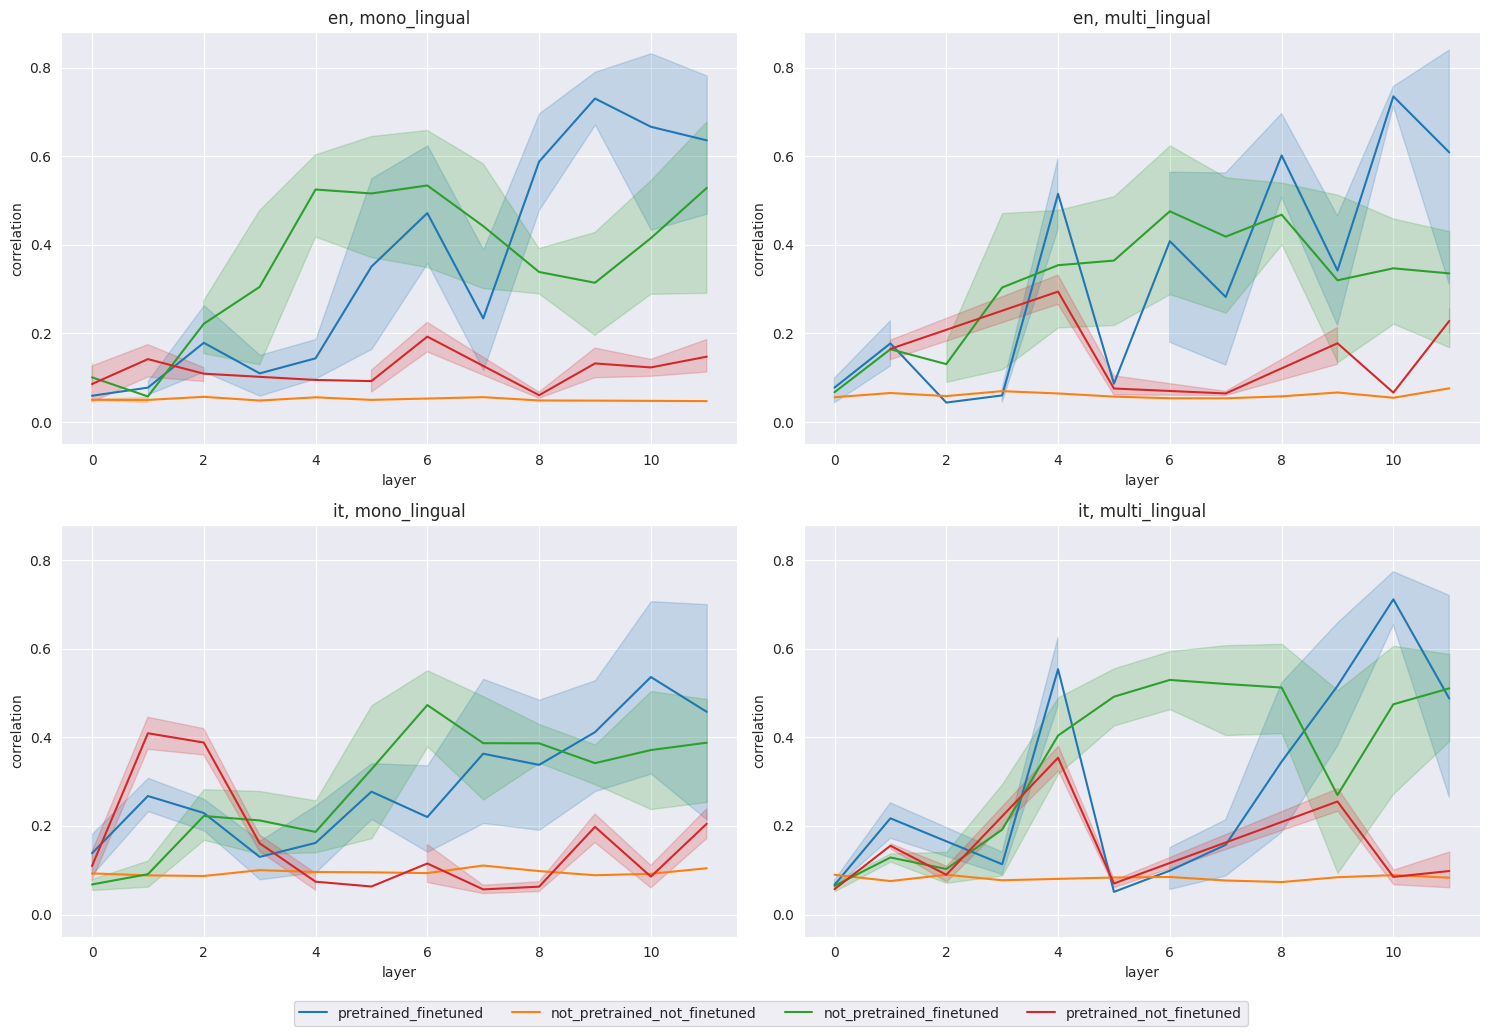

In [18]:
method = 'valuezeroing'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path)

# SST2

In [19]:
task = 'sst2'

## Attention

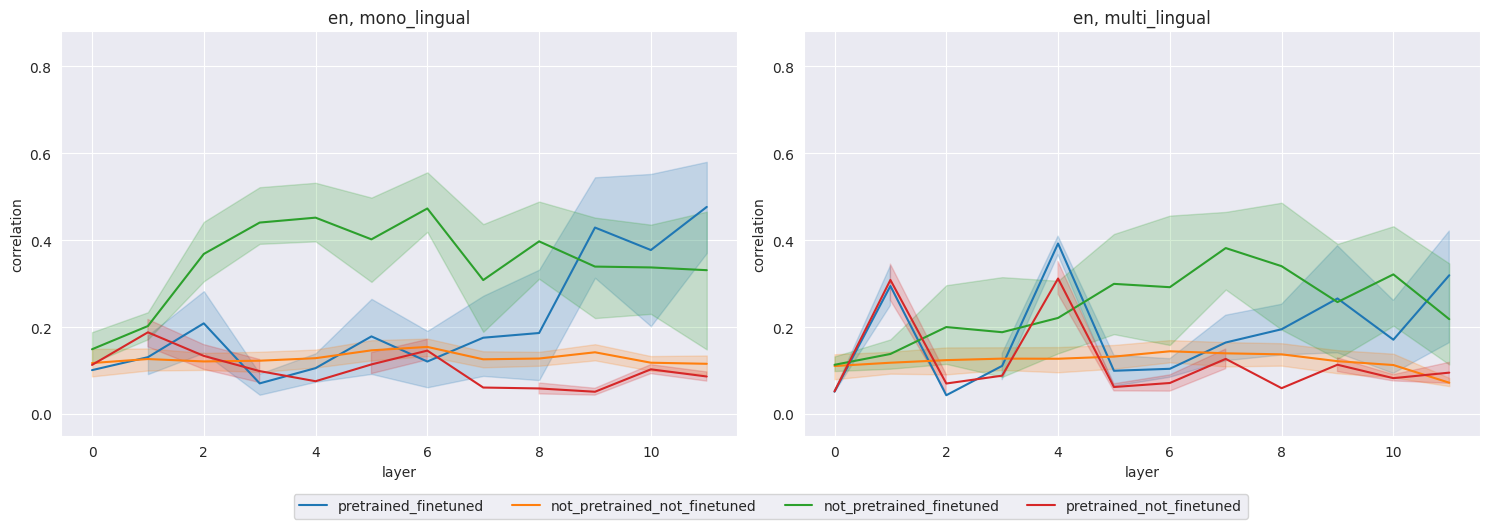

In [20]:
method = 'attention'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path, languages=['en'])

## Alti

/home/luca/Workspace/augmenting_nlms_meco/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


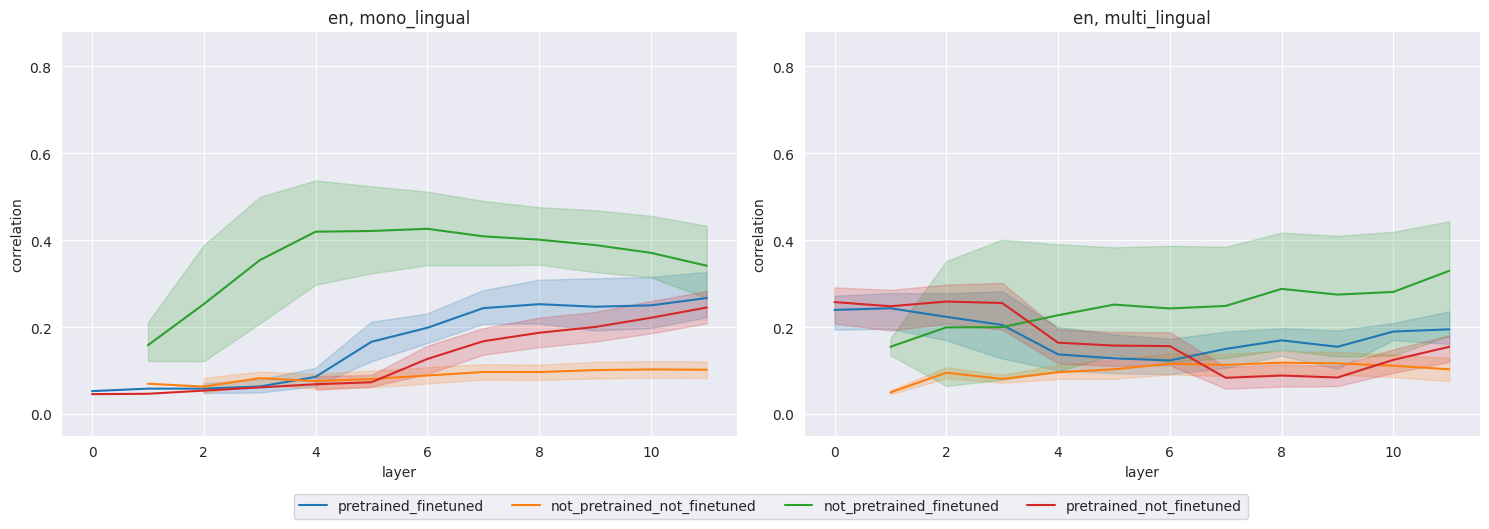

In [21]:
method = 'alti'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path, languages=['en'])

## Valuezeroing

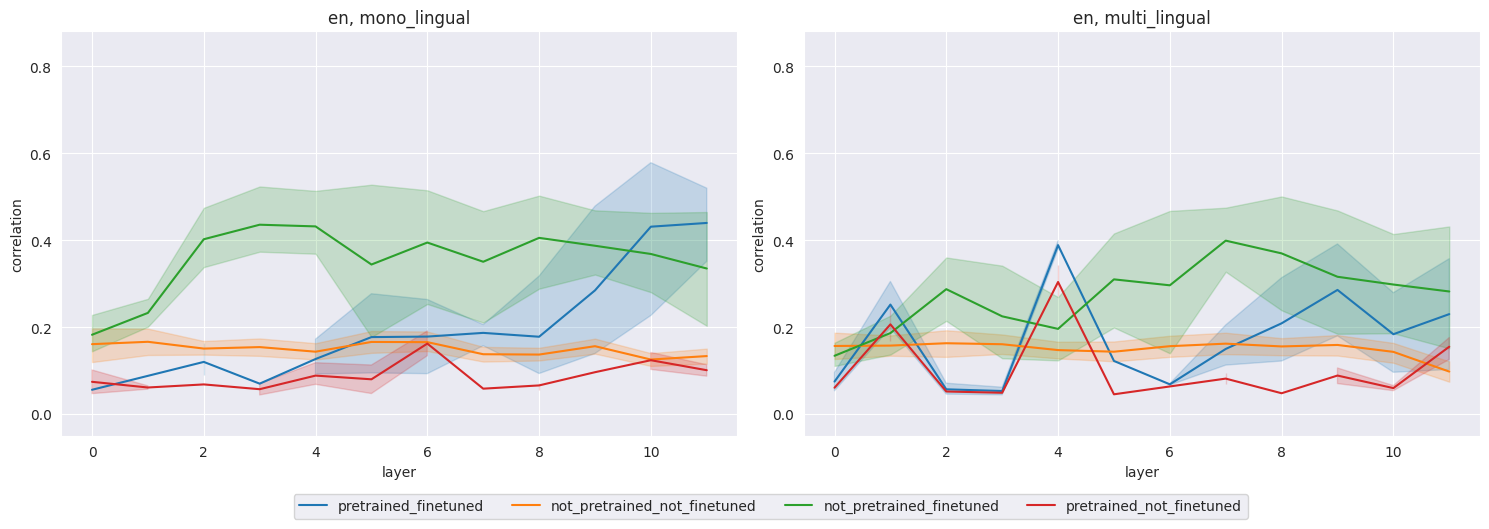

In [22]:
method = 'valuezeroing'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path, languages=['en'])

# Sentipolc

In [23]:
task = 'sentipolc'

## Attention

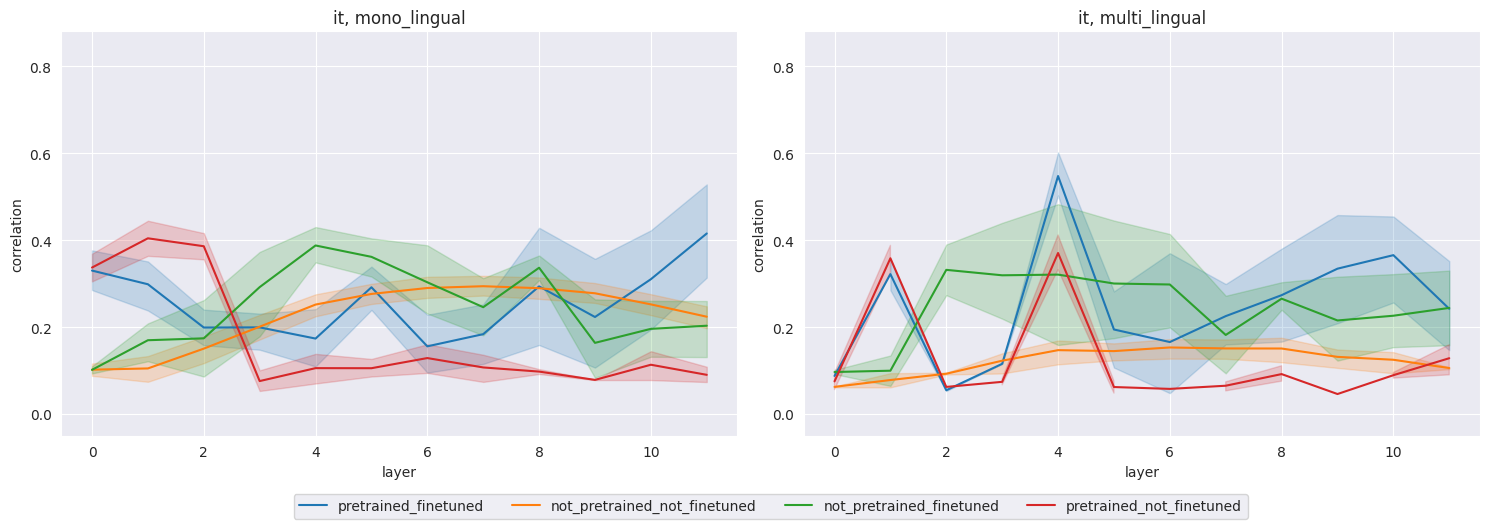

In [24]:
method = 'attention'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path, languages=['it'])

## Alti

/home/luca/Workspace/augmenting_nlms_meco/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/luca/Workspace/augmenting_nlms_meco/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


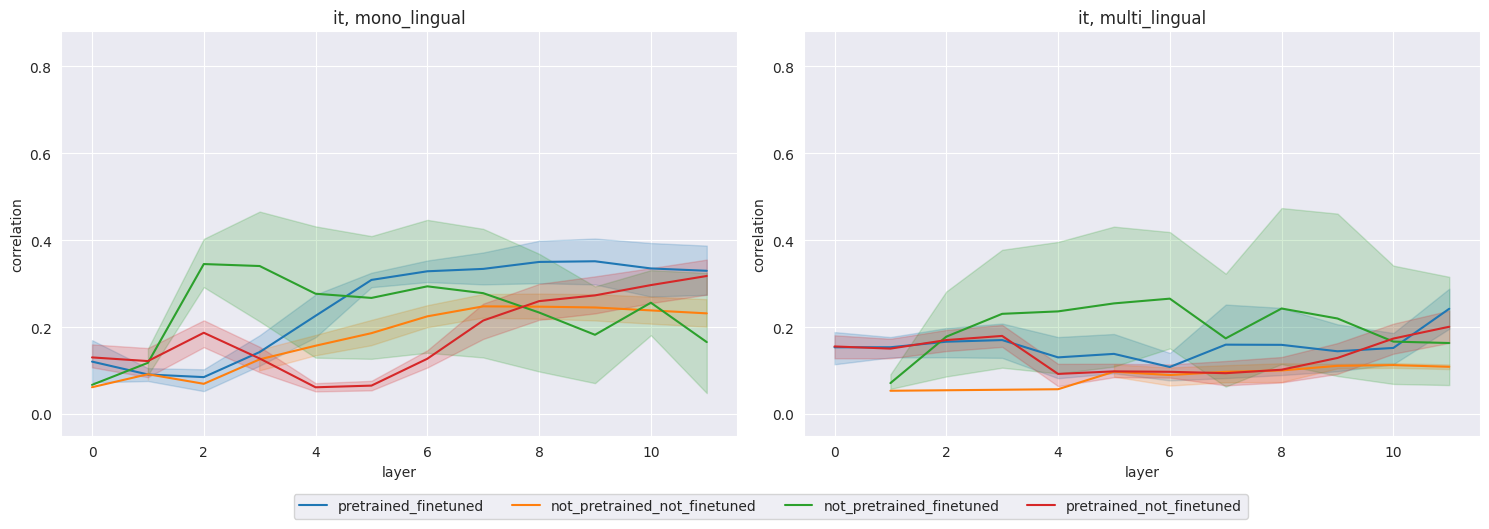

In [25]:
method = 'alti'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path, languages=['it'])

## Valuezeroing

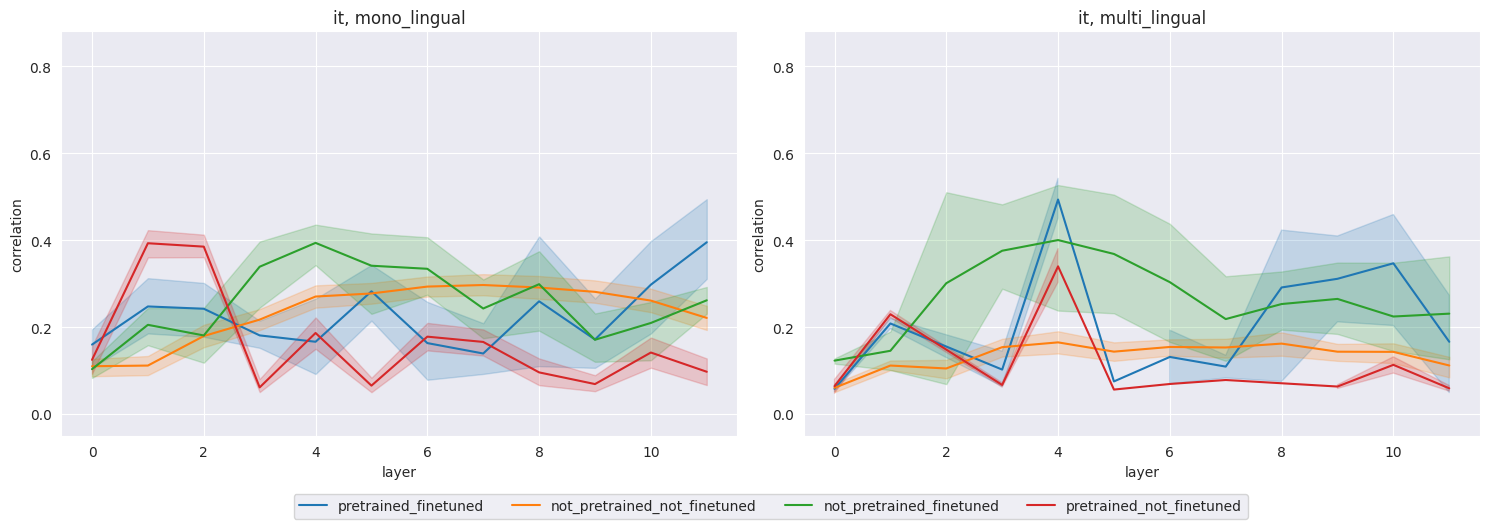

In [26]:
method = 'valuezeroing'
out_path = os.path.join(out_dir, f'{task}_{method}_{eye_tracking_feature}.png')
plot_all_correlations(task, method, out_path, languages=['it'])